In [ ]:
# This R environment comes with many helpful analytics packages installed
# It is defined by the kaggle/rstats Docker image: https://github.com/kaggle/docker-rstats
# For example, here's a helpful package to load

library(tidyverse) # metapackage of all tidyverse packages

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

list.files(path = "../input")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Tarea 1 - Momentos Estadísticos en Series de Tiempo Financieras
1. Descarga de la serie de precios de dos activos estándares: Stock y un Bono.
Fechas: 1ro enero 2018 al 01 Enero 2021.
2. Análisis de las series:
• Media, Varianza, Sesgo y Curtosis de log-rendimientos.
• Realice pruebas de hipótesis de cero: media, sesgo, y curtosis. 
  Prueba de normalidad JB o Shapiro
• Con base a los cuatro momentos estadísticos, comente y compare las series.
• Entregar documento tipo pdf autocontenido con código, resultados e interpretaciones

### 1. Parte 1: Obtención de datos y grafico de rendimientos.
### 2. Estaísticas Basicas y Análisis Momentos: Media, sesgo y curtosis.
### 3. Visualización de distribuciones

In [28]:
library(fBasics)
library(PerformanceAnalytics)
library(xts)
library(quantmod)
library(ggplot2)
library(tseries)
library(dygraphs)
options(warn = - 1) 

## 1. Datos
• Fechas: 1ro enero 2020 al 31 diciembre 2021.

In [36]:
start<-format(as.Date("2020-01-01"),"%Y-%m-%d")
end<-format(as.Date("2021-12-31"),"%Y-%m-%d")
rend<-function(simbolo) {
  ##---------Obtener precios de yahoo finance:
  datos<-getSymbols(simbolo,  from=start, to= end, auto.assign = FALSE)
  ##---------eliminar datos faltantes:
  datos<-na.omit(datos)
  ##--------Mantener el precio de interés:
  datos<-datos[,4]
  ##--------Rendimientos simples:
  rend<-periodReturn(datos, period = "daily", type='arithmetic')                                              
  #------ --Para hacer dtos accesibles  GLobal ENv:
  assign(simbolo, rend, envir = .GlobalEnv)
}


In [37]:
rend("ETH-USD")  #Ethereum (cryptomoneda)

head(`ETH-USD`)

In [38]:
rends<-merge.xts(`ETH-USD`)
colnames(rends)<-c("ETH-USD")
dygraph(rends, main = "ETH-USD Rendimientos") %>%
  dyAxis("y", label = "Rend %") %>%
  dyOptions(colors = RColorBrewer::brewer.pal(4, "Set1"))

## 2. Estadísticas y análisis momentos

Recordar que para medir estadísticamente la significancia del sesgo, empleamos las siguientes pruebas de hipótesis:

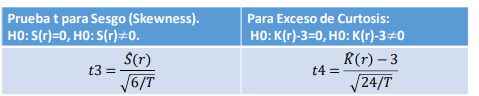

Donde S(r) y K(r) son los resultados de las funciones en R:

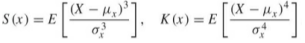

Donde en el caso de curtosis, el programa calcula el exceso de curtosis. Comencemos calculando los primeros momentos y vamos a definir si la media de los rendimientos es o no igual a cero:

In [41]:
basicStats(`ETH-USD`) ## Resumen estadisticos

In [42]:
mean(`ETH-USD`)
var(`ETH-USD`)
stdev(`ETH-USD`) # Desv Std

Se evalúa si la media de los rendimientos es igual o diferente de cero, a un nivel del alfa=0.05.

In [43]:
t.test(`ETH-USD`)  # Prueba que H0: mean return = 0

Al aplicar la prueba t encontramos que el p-value esta en zona de rechazo, por tanto, se rechaza la H0 y se puede decir que la media es estadísticamente distinta de cero. Ahora seguimos con el tercer momento (sesgo):

In [44]:
s3=skewness(`ETH-USD`)  #Sesgo
T=length(`ETH-USD`) # N
t3=s3/sqrt(6/T) # Prueba de sesgo
t3

El sesgo es negativo. Ahora se determina la significancia de dicho sesgo con prueba de hpotesis mediante el calculo del p-valor:

In [45]:
pp=2*pt(abs(t3), T-1, lower=FALSE) # H0: Sesgo=0 
pp


Como el pp es menor al nivel de significancia 0.05 se encuentra la H0 en zona de rechazo, por lo cual se puede concluir que el sesgo es estadísticamente diferente de cero. 
Ahora validamos en el caso de la curtosis:

In [46]:
s4=kurtosis(`ETH-USD`)
s4
t4=s4/sqrt(24/T) # Prueba de curtosis, en exceso
t4
pv=2*(1-pnorm(t4)) # p-valor, H0:curtosis=0
pv


En este caso la curtosis es diferente de cero, esto dado que el pv es menor al nivel de significancia, es decir, se rechaza la hipótesis nula (k=0)

Finalmente, se determina si la distribución es o no normal. Podemos usar Jarque Bera o Shapiro. En este caso usamos JB:

In [47]:
normalTest(`ETH-USD`,method='jb') # Prueba Jaque Bera, H0: Normal

El p-value resultante esta dentro de la zona de rechazo, por lo cual se rechaza H0, es decir, que la distribución no es normal.


Ahora se muestra su comportamiento mediante sus distribuciones:

In [48]:
library(PerformanceAnalytics)
par(mfrow=c(1,1))
chart.Histogram(`ETH-USD`, methods = c("add.normal", "add.density"), colorset = c("gray", "blue", "red"))
legend("topright", legend = c("Hist-Ethereum" ,"ETH-USD dist","dnorm ETH-USD"), col=c("gray", "blue", "red"), lty=1, cex = 0.7)

De manera general, podemos concluir que la acción de Ethereum esta dominado por su clima de incertidumbre actual respecto a la volatilidad propia que aún presenta una criptomoneda, en este caso se encuentra un comportamiento leptocúrtico, con una media de rendimientos estadísticamente distinta de cero, sesgada negativamente y con un exceso de curtosis positivo significativo; lo que permite mostrar que es una acción altamente riesgosa. Adicionalmente se encuentra de esta distribución que presenta retornos altos comparado con otros activos como los evaluados previamente (S&P 500 y BND) sin embargo también se ve de su distribución que esto que es altamente sensible a perdidas del mismo nivel, es decir, mayor retorno y mayor volatilidad. En suma, en este análisis que la criptomoneda es rentable pero aún con alto riesgo.